In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import vaeda
import requests
import tarfile
import os
import tempfile
import shutil

In [2]:
#- scanpy tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.0 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [3]:
#- we read the data an clean up "on the fly".

c_wrkdir = os.getcwd()
t_datdir = tempfile.TemporaryDirectory()
os.chdir(t_datdir.name)

url = "http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz"
response = requests.get(url, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=".")

adata = sc.read_10x_mtx(
    './filtered_gene_bc_matrices/hg19/',     # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()

os.chdir(c_wrkdir)
shutil.rmtree(t_datdir.name)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [4]:
%%capture vaeda_msgs
#- need to work on vaeda's progress msgs
X = np.array(adata.X.todense())
preds, preds_on_P, calls, encoding, knn_feature = vaeda.vaeda(X)

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


2022-05-01 21:15:14.263749: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 21:15:14.377475: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
#- save vaeda scores and calls
adata.obs['vaeda_scores'] = preds
adata.obs['vaeda_calls']  = calls
adata.obs

,vaeda_scores,vaeda_calls
AAACATACAACCAC-1,0.093961,singlet
AAACATTGAGCTAC-1,0.129545,singlet
AAACATTGATCAGC-1,0.094901,singlet
AAACCGTGCTTCCG-1,0.040199,singlet
AAACCGTGTATGCG-1,0.000495,singlet
...,...,...
TTTCGAACTCTCAT-1,0.055550,singlet
TTTCTACTGAGGCA-1,0.546710,singlet
TTTCTACTTCCTCG-1,0.003657,singlet
TTTGCATGAGAGGC-1,0.001198,singlet


In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [8]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/dennis/miniconda3/envs/vaeda_env/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/dennis/miniconda3/envs/vaeda_env/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/Users/dennis/miniconda3/envs/vaeda_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


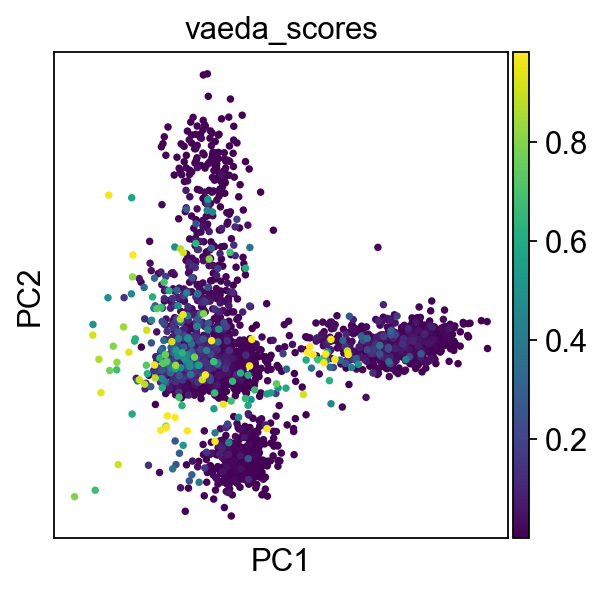

In [9]:
sc.pl.pca(adata, color='vaeda_scores')

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata,init_pos='paga', min_dist=1.0, maxiter=200)


computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


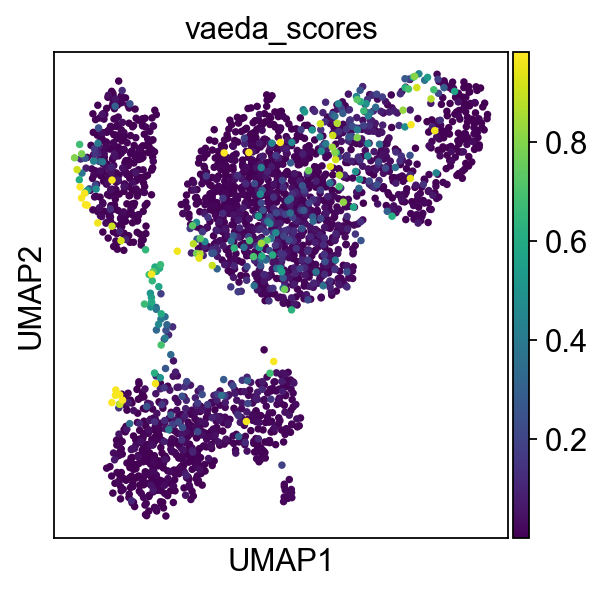

In [11]:
sc.pl.umap(adata, color=['vaeda_scores'])